<a href="https://colab.research.google.com/github/abhizc/EVA4-B2/blob/master/S5/SecondCode_S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Target:** To increase the accuracy

1.   Adding Batch normalization

**Results:**


1.   Parameters: 8,604
2.   Best Train Accuracy: 99.24%
3.   Best Test Accuracy: 98.93%


**Analysis:**

Model over-fitting.

Test Accuracy needs to be improved

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


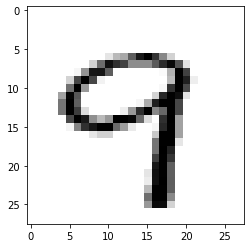

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

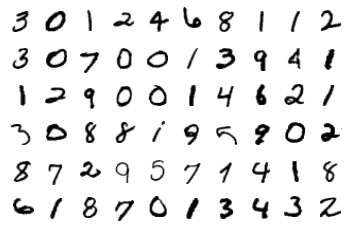

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 26


        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 24


        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.ReLU()
        ) # output_size = 7

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,296
       BatchNorm2d-5           [-1, 12, 24, 24]              24
              ReLU-6           [-1, 12, 24, 24]               0
            Conv2d-7           [-1, 24, 22, 22]           2,592
       BatchNorm2d-8           [-1, 24, 22, 22]              48
              ReLU-9           [-1, 24, 22, 22]               0
        MaxPool2d-10           [-1, 24, 11, 11]               0
           Conv2d-11           [-1, 12, 11, 11]             288
      BatchNorm2d-12           [-1, 12, 11, 11]              24
             ReLU-13           [-1, 12, 11, 11]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.17730022966861725 Batch_id=468 Accuracy=82.28: 100%|██████████| 469/469 [00:09<00:00, 48.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2101, Accuracy: 9454/10000 (94.54%)

EPOCH: 1


Loss=0.0852942243218422 Batch_id=468 Accuracy=97.02: 100%|██████████| 469/469 [00:09<00:00, 48.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0870, Accuracy: 9763/10000 (97.63%)

EPOCH: 2


Loss=0.06306714564561844 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:09<00:00, 48.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0941, Accuracy: 9717/10000 (97.17%)

EPOCH: 3


Loss=0.07277265936136246 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:09<00:00, 47.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0611, Accuracy: 9826/10000 (98.26%)

EPOCH: 4


Loss=0.048998329788446426 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:09<00:00, 48.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9871/10000 (98.71%)

EPOCH: 5


Loss=0.04450289532542229 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:09<00:00, 48.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9837/10000 (98.37%)

EPOCH: 6


Loss=0.07512622326612473 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:09<00:00, 48.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9855/10000 (98.55%)

EPOCH: 7


Loss=0.07091601938009262 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:09<00:00, 48.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9877/10000 (98.77%)

EPOCH: 8


Loss=0.04672747850418091 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:09<00:00, 48.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9861/10000 (98.61%)

EPOCH: 9


Loss=0.017369499430060387 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:09<00:00, 48.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9891/10000 (98.91%)

EPOCH: 10


Loss=0.12843044102191925 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:10<00:00, 46.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9868/10000 (98.68%)

EPOCH: 11


Loss=0.025280574336647987 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:09<00:00, 48.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9889/10000 (98.89%)

EPOCH: 12


Loss=0.018015583977103233 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:09<00:00, 48.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9884/10000 (98.84%)

EPOCH: 13


Loss=0.022207921370863914 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:09<00:00, 48.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9887/10000 (98.87%)

EPOCH: 14


Loss=0.006922359112650156 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:09<00:00, 48.91it/s]



Test set: Average loss: 0.0345, Accuracy: 9893/10000 (98.93%)



Text(0.5, 1.0, 'Test Accuracy')

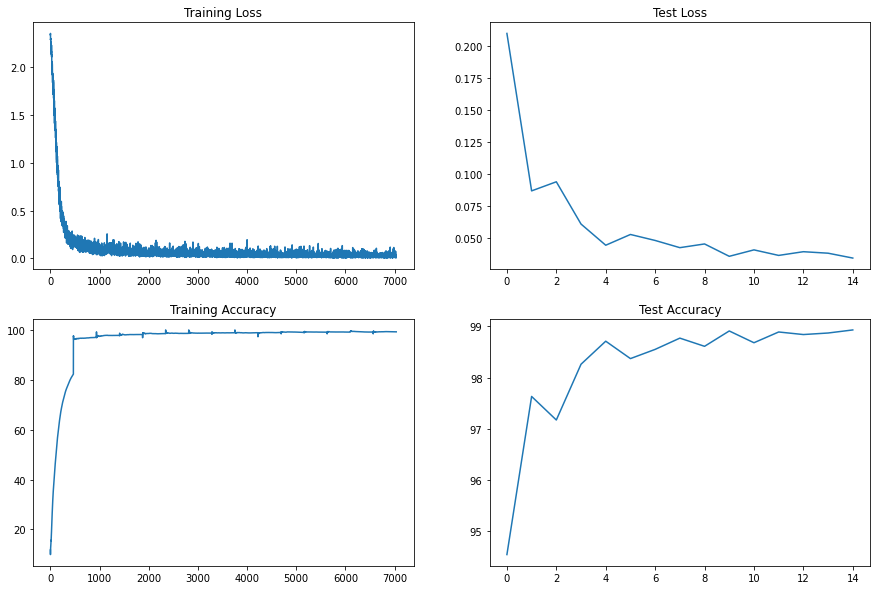

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")